
== ABC ==
Thời gian chạy (s): 2.005918
Best f(x):          11.999972503577
Check lại f(x*):    11.999972503577

Nghiệm x* = [rho, phi1..phiM]:
[ 0.        1.797147 -1.078742 -2.265975  0.788378 -0.510308  0.327563
 -1.11316  -2.029672 -1.431661  0.070159  1.114217 -0.326588]

Rho*:
0.0

Vector pha tối ưu phi*:
[ 1.797147 -1.078742 -2.265975  0.788378 -0.510308  0.327563 -1.11316
 -2.029672 -1.431661  0.070159  1.114217 -0.326588]

||wt*|| (chuẩn hoá công suất):
0.9999999999999999

Vector beam tối ưu wt* (complex):
[ 0.2481  -0.147579j  0.135225-0.255044j -0.016574-0.288199j
 -0.163513-0.237901j -0.263687-0.117483j -0.286476+0.035561j
 -0.226145+0.17942j  -0.100752+0.270523j  0.05325 +0.283721j
  0.193543+0.214183j  0.276532+0.082845j  0.279339-0.072823j]

== GABC ==
Thời gian chạy (s): 2.053522
Best f(x):          12.000000000000
Check lại f(x*):    12.000000000000

Nghiệm x* = [rho, phi1..phiM]:
[ 2.065382e-15  7.935456e-01 -2.081211e+00  3.014172e+00 -2.154778e-01
 -1.510198e+00 -6.

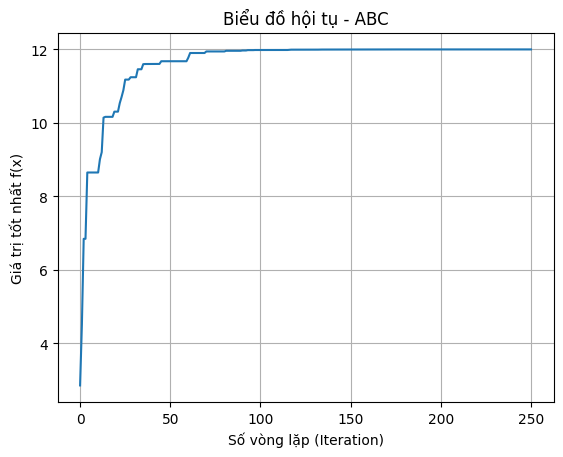

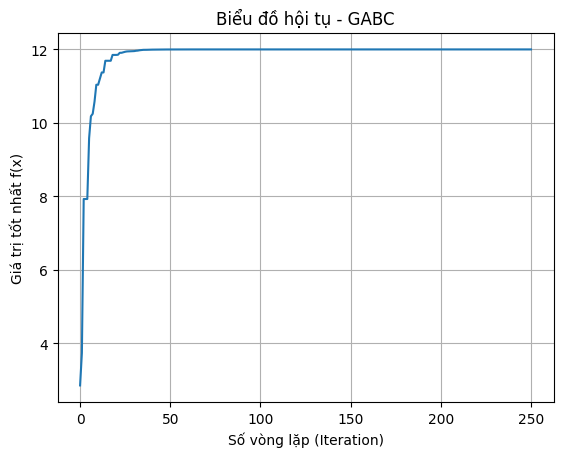

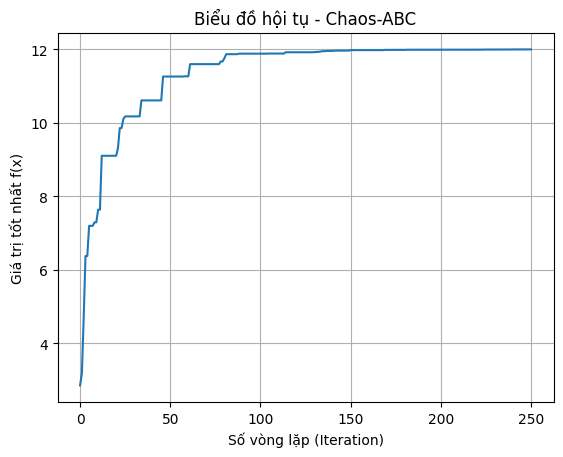

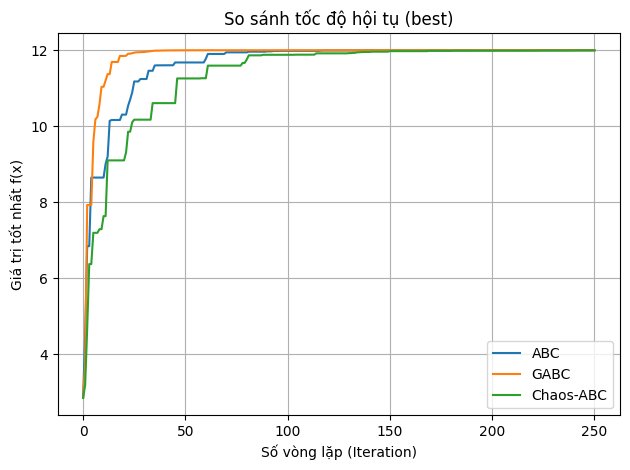

In [8]:
import numpy as np
import time
import matplotlib.pyplot as plt


# ============================================================
# 0) HÀM PHỤ TRỢ: wrap pha, ép miền, roulette-wheel
# ============================================================

def wrap_to_pi(phi: np.ndarray) -> np.ndarray:
    """
    Đưa pha về miền [-pi, pi] do tính tuần hoàn:
      phi và phi + 2*pi là tương đương.
    """
    return ((phi + np.pi) % (2.0 * np.pi)) - np.pi


def bound_and_wrap(x: np.ndarray) -> np.ndarray:
    """
    Ép nghiệm x = [rho, phi1..phiM] vào miền hợp lệ:
      - rho ∈ [0, 1]
      - phi_i ∈ [-pi, pi] (wrap)
    """
    y = x.copy()
    y[0] = np.clip(y[0], 0.0, 1.0)
    y[1:] = wrap_to_pi(y[1:])
    return y


def roulette_wheel_select(probs: np.ndarray, rng: np.random.Generator) -> int:
    """
    Roulette-wheel selection:
      - probs >= 0 và sum(probs) = 1
      - trả về chỉ số được chọn theo xác suất probs
    """
    cdf = np.cumsum(probs)
    r = rng.random()
    return int(np.searchsorted(cdf, r, side="right"))


# ============================================================
# 1) MÔ HÌNH MULTIBEAM + HÀM MỤC TIÊU
# ============================================================

def build_wt(x: np.ndarray, wt_c: np.ndarray, wt_s: np.ndarray, normalize: bool = True) -> np.ndarray:
    """
    Mô hình multibeam với biến quyết định:
      x = [rho, phi1, ..., phiM]

    Vector beamforming phát:
      wt(x) = sqrt(rho)*wt_c + sqrt(1-rho)*( exp(j*phi) ⊙ wt_s )

    Trong đó:
      - rho ∈ [0,1]: hệ số chia công suất
      - phi: vector pha kết hợp tại từng phần tử anten
      - ⊙: nhân theo từng phần tử

    Nếu normalize=True: chuẩn hoá wt để đảm bảo ràng buộc công suất ||wt|| = 1.
    """
    rho = float(x[0])
    phi = x[1:]  # (M,)

    sensing_rot = np.exp(1j * phi) * wt_s
    wt = np.sqrt(rho) * wt_c + np.sqrt(1.0 - rho) * sensing_rot

    if not normalize:
        return wt

    nrm = np.linalg.norm(wt)
    if nrm < 1e-12:
        # Trường hợp hiếm: tránh chia 0
        # Fallback về wt_c (giả sử wt_c đã chuẩn hoá)
        return wt_c.copy()

    return wt / nrm


def steering_vector_ula(M: int, theta: float) -> np.ndarray:
    """
    Vector hướng cho mảng tuyến tính đều (ULA), khoảng cách d = lambda/2:
      a(theta) = [1, e^{j*pi*sin(theta)}, ..., e^{j*pi*(M-1)*sin(theta)}]^T
    """
    m = np.arange(M, dtype=float)
    return np.exp(1j * np.pi * m * np.sin(theta)).astype(complex)


def objective_known_H(x: np.ndarray, A: np.ndarray, wt_c: np.ndarray, wt_s: np.ndarray) -> float:
    """
    Case 1: Biết đầy đủ ma trận kênh H.

    Đặt A = H^H H (ma trận năng lượng kênh).

    Với wt đã chuẩn hoá ||wt|| = 1:
      f(x) = wt^H * A * wt

    Do A là bán xác định dương => f(x) >= 0 (sai số số học thì kẹp về 0).
    """
    wt = build_wt(x, wt_c, wt_s, normalize=True)
    val = np.vdot(wt, A @ wt).real
    return float(max(val, 0.0))


def objective_known_AoD(x: np.ndarray, a_theta: np.ndarray, wt_c: np.ndarray, wt_s: np.ndarray) -> float:
    """
    Case 2: Chỉ biết AoD trội (dominating AoD) theta_t.

    Với wt đã chuẩn hoá ||wt|| = 1:
      f_tilde(x) = | a^T(theta_t) * wt |^2

    Lưu ý: công thức dùng a^T (transpose) (không liên hợp).
    """
    wt = build_wt(x, wt_c, wt_s, normalize=True)
    gain = a_theta.T @ wt
    return float(np.abs(gain) ** 2)


# ============================================================
# 2) FITNESS
# ============================================================

def fitness_from_f(fval: float) -> float:
    """
    Fitness theo công thức:
      fit = 1 / (1 + 1/f)  nếu f > 0
      fit = 0              nếu f <= 0

    Đây là hàm tăng đơn điệu theo f, giữ nguyên thứ tự nghiệm,
    đồng thời giúp roulette-wheel ổn định hơn khi f biến thiên.
    """
    if fval > 0.0:
        return 1.0 / (1.0 + 1.0 / fval)
    return 0.0


def evaluate_population(X: np.ndarray, objective_fn) -> tuple[np.ndarray, np.ndarray]:
    """
    Tính cho toàn bộ quần thể:
      - fvals[i] = objective(x_i)
      - fits[i]  = fitness_from_f(fvals[i])
    """
    fvals = np.array([objective_fn(x) for x in X], dtype=float)
    fits = np.array([fitness_from_f(v) for v in fvals], dtype=float)
    return fvals, fits


def init_population(SN: int, M: int, rng: np.random.Generator) -> np.ndarray:
    """
    Khởi tạo quần thể nghiệm x = [rho, phi1..phiM]:
      - rho ~ U(0,1)
      - phi_i ~ U(-pi, pi)
    """
    X = np.empty((SN, M + 1), dtype=float)
    X[:, 0] = rng.random(SN)
    X[:, 1:] = rng.uniform(-np.pi, np.pi, size=(SN, M))
    return X


# ============================================================
# 3) ABC / GABC / Chaos-ABC
# ============================================================

def neighbor_abc(xi: np.ndarray, xk: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    """
    Sinh nghiệm lân cận (ABC):
      v = xi + phi ⊙ (xi - xk)
      phi ~ U[-1, 1]
    """
    D = xi.size
    phi = rng.uniform(-1.0, 1.0, size=D)
    v = xi + phi * (xi - xk)
    return bound_and_wrap(v)


def neighbor_gabc(xi: np.ndarray, xk: np.ndarray, x_best: np.ndarray,
                  rng: np.random.Generator, C: float) -> np.ndarray:
    """
    Sinh nghiệm lân cận (GABC):
      v = xi + phi ⊙ (xi - xk) + psi ⊙ (x_best - xi)
      phi ~ U[-1, 1], psi ~ U[0, C]
    """
    D = xi.size
    phi = rng.uniform(-1.0, 1.0, size=D)
    psi = rng.uniform(0.0, C, size=D)
    v = xi + phi * (xi - xk) + psi * (x_best - xi)
    return bound_and_wrap(v)


class LogisticChaos:
    """
    Logistic map (chuỗi hỗn loạn):
      u_{t+1} = mu * u_t * (1 - u_t), u ∈ (0, 1)
    """
    def __init__(self, u0: float = 0.231, mu: float = 4.0):
        if not (0.0 < u0 < 1.0):
            raise ValueError("u0 phải thuộc (0,1)")
        self.u = float(u0)
        self.mu = float(mu)

    def next(self) -> float:
        self.u = self.mu * self.u * (1.0 - self.u)
        # tránh sát biên 0/1 gây suy biến
        self.u = float(min(max(self.u, 1e-12), 1.0 - 1e-12))
        return self.u

    def vec01(self, D: int) -> np.ndarray:
        out = np.empty(D, dtype=float)
        for i in range(D):
            out[i] = self.next()
        return out


def neighbor_chaos_abc(xi: np.ndarray, xk: np.ndarray, chaos: LogisticChaos) -> np.ndarray:
    """
    Sinh nghiệm lân cận (Chaos-ABC):
      - thay biến ngẫu nhiên phi bằng chuỗi hỗn loạn logistic
      - phi = 2u - 1 ∈ [-1, 1]

      v = xi + phi ⊙ (xi - xk)
    """
    D = xi.size
    u = chaos.vec01(D)
    phi = 2.0 * u - 1.0
    v = xi + phi * (xi - xk)
    return bound_and_wrap(v)


def abc_optimize(M: int, objective_fn,
                 SN: int = 40, max_iter: int = 250, limit: int = 30, seed: int = 1):
    """
    Thuật toán ABC cho tối ưu đa biến x = (rho, phi1..phiM)

    Pha chính:
      (1) Employed bees: tạo nghiệm lân cận và chọn lọc
      (2) Onlooker bees: chọn nghiệm theo roulette-wheel dựa trên fitness
      (3) Scout bees: tái khởi tạo nếu trial >= limit
    """
    rng = np.random.default_rng(seed)

    X = init_population(SN, M, rng)
    X = np.array([bound_and_wrap(x) for x in X])
    trials = np.zeros(SN, dtype=int)

    fvals, fits = evaluate_population(X, objective_fn)

    best_idx = int(np.argmax(fvals))
    x_best = X[best_idx].copy()
    f_best = float(fvals[best_idx])

    hist_best = [f_best]
    hist_mean = [float(np.mean(fvals))]

    t0 = time.perf_counter()

    for _ in range(max_iter):

        # (1) Employed bees
        for i in range(SN):
            k = i
            while k == i:
                k = rng.integers(0, SN)

            v = neighbor_abc(X[i], X[k], rng)
            fv = objective_fn(v)
            fitv = fitness_from_f(fv)

            if fitv > fits[i]:
                X[i] = v
                fvals[i] = fv
                fits[i] = fitv
                trials[i] = 0
            else:
                trials[i] += 1

        # (2) Onlooker bees
        fit_sum = float(np.sum(fits))
        probs = (fits / fit_sum) if fit_sum > 1e-15 else (np.ones(SN) / SN)

        for _ in range(SN):
            i = roulette_wheel_select(probs, rng)

            k = i
            while k == i:
                k = rng.integers(0, SN)

            v = neighbor_abc(X[i], X[k], rng)
            fv = objective_fn(v)
            fitv = fitness_from_f(fv)

            if fitv > fits[i]:
                X[i] = v
                fvals[i] = fv
                fits[i] = fitv
                trials[i] = 0
            else:
                trials[i] += 1

        # (3) Scout bees
        for i in range(SN):
            if trials[i] >= limit:
                X[i, 0] = rng.random()
                X[i, 1:] = rng.uniform(-np.pi, np.pi, size=M)
                X[i] = bound_and_wrap(X[i])

                fvals[i] = objective_fn(X[i])
                fits[i] = fitness_from_f(fvals[i])
                trials[i] = 0

        # Cập nhật nghiệm tốt nhất theo f
        cur_best_idx = int(np.argmax(fvals))
        if fvals[cur_best_idx] > f_best:
            x_best = X[cur_best_idx].copy()
            f_best = float(fvals[cur_best_idx])

        hist_best.append(f_best)
        hist_mean.append(float(np.mean(fvals)))

    elapsed = time.perf_counter() - t0

    return {
        "name": "ABC",
        "x_best": x_best,
        "f_best": f_best,
        "elapsed_sec": float(elapsed),
        "hist_best_f": np.array(hist_best, dtype=float),
        "hist_mean_f": np.array(hist_mean, dtype=float),
    }


def gabc_optimize(M: int, objective_fn,
                  SN: int = 40, max_iter: int = 250, limit: int = 30, C: float = 1.2, seed: int = 1):
    """
    Thuật toán GABC: ABC có dẫn hướng theo nghiệm tốt nhất toàn cục x_best.

    Công thức lân cận:
      v = xi + phi ⊙ (xi - xk) + psi ⊙ (x_best - xi)
      phi ~ U[-1,1], psi ~ U[0,C]
    """
    rng = np.random.default_rng(seed)

    X = init_population(SN, M, rng)
    X = np.array([bound_and_wrap(x) for x in X])
    trials = np.zeros(SN, dtype=int)

    fvals, fits = evaluate_population(X, objective_fn)

    best_idx = int(np.argmax(fvals))
    x_best = X[best_idx].copy()
    f_best = float(fvals[best_idx])

    hist_best = [f_best]
    hist_mean = [float(np.mean(fvals))]

    t0 = time.perf_counter()

    for _ in range(max_iter):

        # (1) Employed bees
        for i in range(SN):
            k = i
            while k == i:
                k = rng.integers(0, SN)

            v = neighbor_gabc(X[i], X[k], x_best, rng, C=C)
            fv = objective_fn(v)
            fitv = fitness_from_f(fv)

            if fitv > fits[i]:
                X[i] = v
                fvals[i] = fv
                fits[i] = fitv
                trials[i] = 0
            else:
                trials[i] += 1

        # (2) Onlooker bees
        fit_sum = float(np.sum(fits))
        probs = (fits / fit_sum) if fit_sum > 1e-15 else (np.ones(SN) / SN)

        for _ in range(SN):
            i = roulette_wheel_select(probs, rng)

            k = i
            while k == i:
                k = rng.integers(0, SN)

            v = neighbor_gabc(X[i], X[k], x_best, rng, C=C)
            fv = objective_fn(v)
            fitv = fitness_from_f(fv)

            if fitv > fits[i]:
                X[i] = v
                fvals[i] = fv
                fits[i] = fitv
                trials[i] = 0
            else:
                trials[i] += 1

        # (3) Scout bees
        for i in range(SN):
            if trials[i] >= limit:
                X[i, 0] = rng.random()
                X[i, 1:] = rng.uniform(-np.pi, np.pi, size=M)
                X[i] = bound_and_wrap(X[i])

                fvals[i] = objective_fn(X[i])
                fits[i] = fitness_from_f(fvals[i])
                trials[i] = 0

        # Cập nhật nghiệm tốt nhất theo f
        cur_best_idx = int(np.argmax(fvals))
        if fvals[cur_best_idx] > f_best:
            x_best = X[cur_best_idx].copy()
            f_best = float(fvals[cur_best_idx])

        hist_best.append(f_best)
        hist_mean.append(float(np.mean(fvals)))

    elapsed = time.perf_counter() - t0

    return {
        "name": "GABC",
        "x_best": x_best,
        "f_best": f_best,
        "elapsed_sec": float(elapsed),
        "hist_best_f": np.array(hist_best, dtype=float),
        "hist_mean_f": np.array(hist_mean, dtype=float),
    }


def chaos_abc_optimize(M: int, objective_fn,
                       SN: int = 40, max_iter: int = 250, limit: int = 30,
                       u0: float = 0.231, mu: float = 4.0, seed: int = 1):
    """
    Thuật toán Chaos-ABC: thay nguồn ngẫu nhiên bằng chuỗi hỗn loạn logistic.

    Trong công thức lân cận:
      phi = 2u - 1, u sinh từ logistic map.
    """
    rng = np.random.default_rng(seed)
    chaos = LogisticChaos(u0=u0, mu=mu)

    X = init_population(SN, M, rng)
    X = np.array([bound_and_wrap(x) for x in X])
    trials = np.zeros(SN, dtype=int)

    fvals, fits = evaluate_population(X, objective_fn)

    best_idx = int(np.argmax(fvals))
    x_best = X[best_idx].copy()
    f_best = float(fvals[best_idx])

    hist_best = [f_best]
    hist_mean = [float(np.mean(fvals))]

    t0 = time.perf_counter()

    for _ in range(max_iter):

        # (1) Employed bees
        for i in range(SN):
            k = i
            while k == i:
                k = rng.integers(0, SN)

            v = neighbor_chaos_abc(X[i], X[k], chaos)
            fv = objective_fn(v)
            fitv = fitness_from_f(fv)

            if fitv > fits[i]:
                X[i] = v
                fvals[i] = fv
                fits[i] = fitv
                trials[i] = 0
            else:
                trials[i] += 1

        # (2) Onlooker bees
        fit_sum = float(np.sum(fits))
        probs = (fits / fit_sum) if fit_sum > 1e-15 else (np.ones(SN) / SN)

        for _ in range(SN):
            i = roulette_wheel_select(probs, rng)

            k = i
            while k == i:
                k = rng.integers(0, SN)

            v = neighbor_chaos_abc(X[i], X[k], chaos)
            fv = objective_fn(v)
            fitv = fitness_from_f(fv)

            if fitv > fits[i]:
                X[i] = v
                fvals[i] = fv
                fits[i] = fitv
                trials[i] = 0
            else:
                trials[i] += 1

        # (3) Scout bees (tái khởi tạo để tăng đa dạng)
        for i in range(SN):
            if trials[i] >= limit:
                rho = chaos.next()
                u_phi = np.array([chaos.next() for _ in range(M)], dtype=float)
                phi = (2.0 * u_phi - 1.0) * np.pi

                X[i] = np.concatenate([[rho], phi])
                X[i] = bound_and_wrap(X[i])

                fvals[i] = objective_fn(X[i])
                fits[i] = fitness_from_f(fvals[i])
                trials[i] = 0

        # Cập nhật nghiệm tốt nhất theo f
        cur_best_idx = int(np.argmax(fvals))
        if fvals[cur_best_idx] > f_best:
            x_best = X[cur_best_idx].copy()
            f_best = float(fvals[cur_best_idx])

        hist_best.append(f_best)
        hist_mean.append(float(np.mean(fvals)))

    elapsed = time.perf_counter() - t0

    return {
        "name": "Chaos-ABC",
        "x_best": x_best,
        "f_best": f_best,
        "elapsed_sec": float(elapsed),
        "hist_best_f": np.array(hist_best, dtype=float),
        "hist_mean_f": np.array(hist_mean, dtype=float),
    }


# ============================================================
# 4) DEMO BÀI TOÁN + VẼ HỘI TỤ + IN NGHIỆM
# ============================================================

def demo_problem(M: int = 12, seed: int = 11):
    """
    Tạo dữ liệu minh hoạ:
      - wt_c: beam đều (uniform)
      - wt_s: beam pha ngẫu nhiên
      - H: ma trận kênh chéo (biên độ + pha)
    """
    rng = np.random.default_rng(seed)

    wt_c = np.ones(M, dtype=complex)
    wt_c = wt_c / np.linalg.norm(wt_c)

    wt_s = np.exp(1j * rng.uniform(-np.pi, np.pi, size=M))
    wt_s = wt_s / np.linalg.norm(wt_s)

    amps = rng.uniform(0.3, 1.0, size=M)
    phis = rng.uniform(-np.pi, np.pi, size=M)
    H = np.diag(amps * np.exp(1j * phis))

    return H, wt_c, wt_s


def plot_convergence(result: dict):
    """Vẽ đường hội tụ của nghiệm tốt nhất theo vòng lặp."""
    y = result["hist_best_f"]
    x = np.arange(len(y))
    plt.figure()
    plt.plot(x, y)
    plt.xlabel("Số vòng lặp (Iteration)")
    plt.ylabel("Giá trị tốt nhất f(x)")
    plt.title(f"Biểu đồ hội tụ - {result['name']}")
    plt.grid(True)
    plt.show()


def summarize(result: dict, objective_fn, wt_c: np.ndarray, wt_s: np.ndarray, decimals: int = 6):
    """
    In nghiệm tối ưu:
      - x_best = [rho, phi1..phiM]
      - wt* (đã chuẩn hoá)
      - kiểm tra lại f(x*)
    """
    np.set_printoptions(precision=decimals, suppress=False)

    x = result["x_best"]
    rho = float(x[0])
    phi = x[1:].copy()

    wt_star = build_wt(x, wt_c, wt_s, normalize=True)
    f_check = float(objective_fn(x))

    print("\n" + "=" * 70)
    print(f"== {result['name']} ==")
    print(f"Thời gian chạy (s): {result['elapsed_sec']:.6f}")
    print(f"Best f(x):          {result['f_best']:.12f}")
    print(f"Check lại f(x*):    {f_check:.12f}")

    print("\nNghiệm x* = [rho, phi1..phiM]:")
    print(x)

    print("\nRho*:")
    print(rho)

    print("\nVector pha tối ưu phi*:")
    print(phi)

    print("\n||wt*|| (chuẩn hoá công suất):")
    print(float(np.linalg.norm(wt_star)))

    print("\nVector beam tối ưu wt* (complex):")
    print(wt_star)

def plot_convergence_overlay(results, which="best"):
    """
    Vẽ chồng nhiều đường hội tụ trên cùng 1 biểu đồ.
    results: list các dict result (res_abc, res_gabc, res_chabc, ...)
    which: "best" hoặc "mean"
    """
    plt.figure()

    key = "hist_best_f" if which == "best" else "hist_mean_f"
    ylabel = "Giá trị tốt nhất f(x)" if which == "best" else "Giá trị trung bình f(x)"

    for res in results:
        y = res[key]
        x = np.arange(len(y))
        plt.plot(x, y, label=res["name"])

    plt.xlabel("Số vòng lặp (Iteration)")
    plt.ylabel(ylabel)
    plt.title(f"So sánh tốc độ hội tụ ({which})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



# ============================================================
# 5) CHẠY THỬ: chọn objective (Known H hoặc Known dominating AoD)
# ============================================================

if __name__ == "__main__":

    # -------------------------------
    # Tạo bài toán minh hoạ
    # -------------------------------
    M = 12
    H, wt_c, wt_s = demo_problem(M=M, seed=11)

    # -------------------------------
    # Chọn objective:
    #   (A) Known H: dùng A = H^H H
    #   (B) Known dominating AoD: dùng a(theta_t)
    # -------------------------------

    # (A) Known H
    A = H.conj().T @ H
    objective_fn_known_H = lambda x: objective_known_H(x, A, wt_c, wt_s)

    # (B) Known dominating AoD
    theta_t = 10.0 * np.pi / 180.0  # ví dụ 10 độ
    a_theta = steering_vector_ula(M, theta_t)
    objective_fn_known_AoD = lambda x: objective_known_AoD(x, a_theta, wt_c, wt_s)

    # ---- Chọn 1 trong 2 objective để chạy ----
    # objective_fn = objective_fn_known_H
    objective_fn = objective_fn_known_AoD

    # -------------------------------
    # Tham số thuật toán
    # -------------------------------
    SN = 40
    MAX_ITER = 250
    LIMIT = 30

    # -------------------------------
    # Chạy ABC / GABC / Chaos-ABC
    # -------------------------------
    res_abc = abc_optimize(M, objective_fn, SN=SN, max_iter=MAX_ITER, limit=LIMIT, seed=1)
    res_gabc = gabc_optimize(M, objective_fn, SN=SN, max_iter=MAX_ITER, limit=LIMIT, C=1.2, seed=1)
    res_cabc = chaos_abc_optimize(M, objective_fn, SN=SN, max_iter=MAX_ITER, limit=LIMIT,
                                  u0=0.231, mu=4.0, seed=1)

    # -------------------------------
    # In kết quả
    # -------------------------------
    summarize(res_abc, objective_fn, wt_c, wt_s)
    summarize(res_gabc, objective_fn, wt_c, wt_s)
    summarize(res_cabc, objective_fn, wt_c, wt_s)

    # -------------------------------
    # Vẽ hội tụ
    # -------------------------------
    plot_convergence(res_abc)
    plot_convergence(res_gabc)
    plot_convergence(res_cabc)

    plot_convergence_overlay([res_abc, res_gabc, res_cabc], which="best")

